In [1]:
"""
This file is used to load and run a trained model for evaluation purposes.
"""
import os
import sys
# adding project directory to path, this is a bit hacky and may not work for all
sys.path.insert(0, os.path.abspath(os.path.dirname(os.path.abspath(''))))

import torch
from kbgen.config import rootdir
from kbgen.data.datasets import GSM
from kbgen.utils.log import RunTracker
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
import pandas as pd
plt.style.use("./mine.mplstyle")

In [8]:
# DATA -----------------------------------------------------
device = "cpu" # "cuda:0" if torch.cuda.is_available() else "cpu"
# Load Wandb Run -----------------------------------------------------
# You need to pick a run that is saved locally
# model_name = "07-29-16-36-26queriesnonz-random_rate_L2td4_te4_d512_periodic"
model_name = "07-31-09-10-18MaskOnlyLossAttn-grad_works_L4td4_te4_d512_periodic"
logdir = os.path.join(rootdir, "models", model_name)
run = RunTracker.from_logdir(logdir, force_device=device)
dataset = GSM.from_config(run.config, update=True)
model = run.load_latest_model().to(device)
model.eval()
accuracy = model.accuracy
print(run.config)

Loading model from: /logdir/models/07-31-09-10-18MaskOnlyLossAttn-grad_works_L4td4_te4_d512_periodic/400.pt
{'d_model': 512, 'd_ff_mult': 2, 'nhead': 2, 'num_layers': 4, 'field_encoder_layers': 2, 'field_decoder_layers': 3, 'num_emb': 'periodic', 'tie_numerical_embeddings': False, 'tie_numerical_decoders': False, 'tie_mask_embeddings': True, 'epochs': 1000, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 0, 'dropout': 0.0, 'mask_rate': [-1, 0.5], 'wandb': True, 'tags': ['MaskOnlyLossAttn', 'grad_works'], 'device': 'cpu', 'seed': 42, 'rootdir': '/logdir', 'ckpt': '', 'text_model': 'custom', 'tie_embeddings': True, 'tokenizer': 'gpt2', 'text_decoder_layers': 4, 'text_encoder_layers': 4, 'use_mup': True, 'num_fields': 12, 'vocab_size': 50258, 'fields': Fields([('numerical', ['phone.weight', 'phone.height', 'phone.depth', 'phone.width', 'phone.display_size', 'phone.battery', 'phone.launch.day', 'phone.launch.month', 'phone.launch.year']), ('categorical', ['phone.oem', 'phone.network_edge']

In [9]:
input_dict = dataset.input_dict.iloc[dataset.val_idx].to(device)
attention_mask = dataset.pad_mask_dict.iloc[dataset.val_idx.to(device)

In [10]:

sample_ids = dataset.val_idx:10]
sample_input_dict = dataset.input_dict.iloc[sample_ids].to(device)
sample_attention_mask = dataset.pad_mask_dict.iloc[sample_ids].to(device)
# make up a mask that hides phone.oem
def mask_field(sample_property_mask, field):
    masked_field_idx = dataset.fields.all_fields.index(field)
    sample_property_mask[:, masked_field_idx] = -torch.inf
    
sample_property_mask = torch.zeros(len(sample_ids), len(dataset.fields.all_fields)).to(device)
masked_field = 'phone.oem'
mask_field(sample_property_mask, masked_field)
also_mask = ['phone.weight', 'phone.launch.day', 'phone.launch.month', 'phone.launch.year']
for field in also_mask:
    mask_field(sample_property_mask, field)


sample_output_dict = model(sample_input_dict, sample_attention_mask, sample_property_mask)
pred = sample_output_dict[masked_field].argmax(dim=1)
tgt = sample_input_dict[masked_field+'_idx']
print(*zip(pred.tolist(), tgt.tolist()), sep='\n')
print("accuracy:", (pred == tgt).float().mean().item())

(44, 44)
(72, 72)
(27, 27)
(40, 61)
(37, 35)
(25, 25)
(27, 27)
(81, 81)
(45, 45)
(40, 40)
accuracy: 0.800000011920929


In [11]:
means = {k : v[(v!=dataset.numerical_pad_token_id)& (v!=dataset.categorical_pad_token_id)].float().mean().item() for k, v in input_dict.items()}
medians = {k : v[(v!=dataset.numerical_pad_token_id)& (v!=dataset.categorical_pad_token_id)].median().item() for k, v in input_dict.items() }
modes = {k : v[(v!=dataset.numerical_pad_token_id)& (v!=dataset.categorical_pad_token_id)].mode()[0].item() for k, v in input_dict.items() if k != "<dummy>"}
modes.update({k : (v:=input_dict[k][:, 1:])[(v!=0)&(v!=2)].mode()[0].item() for k in input_dict.text if k != "<dummy>"})

In [12]:
from scipy import stats

def make_data(fields, mask_rates, trials=20):
    torch.manual_seed(42)
    if not isinstance(fields, list):
        fields = [fields]
    accs = {field : defaultdict(list) for field in fields}
    baseline_acc = {}
    baseline_err = {}
    # compute baseline accuracy
    # based on always guessing the mean value
    for field in input_dict.numerical:
        if field == "<dummy>":
            continue
        pred = torch.full_like(input_dict[field], medians[field])
        tgt = input_dict[field]
        mask = tgt != dataset.numerical_pad_token_id
        tgt, pred = tgt[mask], pred[mask]
        norm = tgt.abs()
        rmse = ((tgt - pred) / norm).pow(2).mean().sqrt().item()
        baseline_acc[field] = rmse
        # RMSE Confidence interval
        standard_error_rmse = rmse / np.sqrt(len(tgt)-1) 
        t_value = stats.t.ppf(1-0.05/2, len(tgt)-1)
        baseline_err[field] = t_value * standard_error_rmse
    for field in input_dict.categorical:
        # wilson score: Binomial proportion confidence interval
        tgt = input_dict[field + "_idx"]
        pred = torch.full_like(tgt, modes[field + "_idx"])
        p = accuracy.compute_acc(pred, tgt).item()
        baseline_acc[field] = 1 - p
        z = stats.norm.ppf(1-0.05/2)
        baseline_err[field] = np.sqrt(p * (1 - p) / len(tgt)) * z
    for field in input_dict.text:
        tgt = input_dict[field][:, 1:]
        pred = torch.full_like(tgt, modes[field])
        p = accuracy.compute_acc(pred, tgt).item()
        baseline_acc[field] = 1 - p
        baseline_err[field] = np.sqrt(p * (1 - p) / len(tgt)) * z
        
        
    for mask_rate in mask_rates:
        lists = {field : defaultdict(list) for field in fields}
        for _ in range(trials):
            with torch.no_grad(), warnings.catch_warnings():
                warnings.simplefilter("ignore")
                property_mask = model._sample_property_mask(attention_mask, mask_rate)
                pred = model.get_predictions(input_dict, attention_mask, property_mask)
                tgt = input_dict.copy() 
            for field in input_dict.categorical:
                tgt[field] = input_dict[field+ "_idx"]
            acc = accuracy(pred, tgt)
            acc_u = accuracy(pred, tgt, ~property_mask.to(bool))
            acc_m = accuracy(pred, tgt, property_mask.to(bool))
            for field in fields:
                lists[field]["average"].append(1 - acc[field].item())
                lists[field]["masked"].append(1 - acc_m[field].item())
                lists[field]["unmasked"].append(1 - acc_u[field].item())
                
        for field in fields:
            for mask_state, value in lists[field].items():
                accs[field][mask_state].append(np.mean(value))
                accs[field][mask_state + "_std"].append(np.std(value))
    return accs, baseline_acc, baseline_err

In [13]:
mask_rates = np.linspace(0.01, .99, 10)[::-1]
accs, baseline_acc, baseline_err = make_data(run.config.fields.all_fields, mask_rates, trials=10)

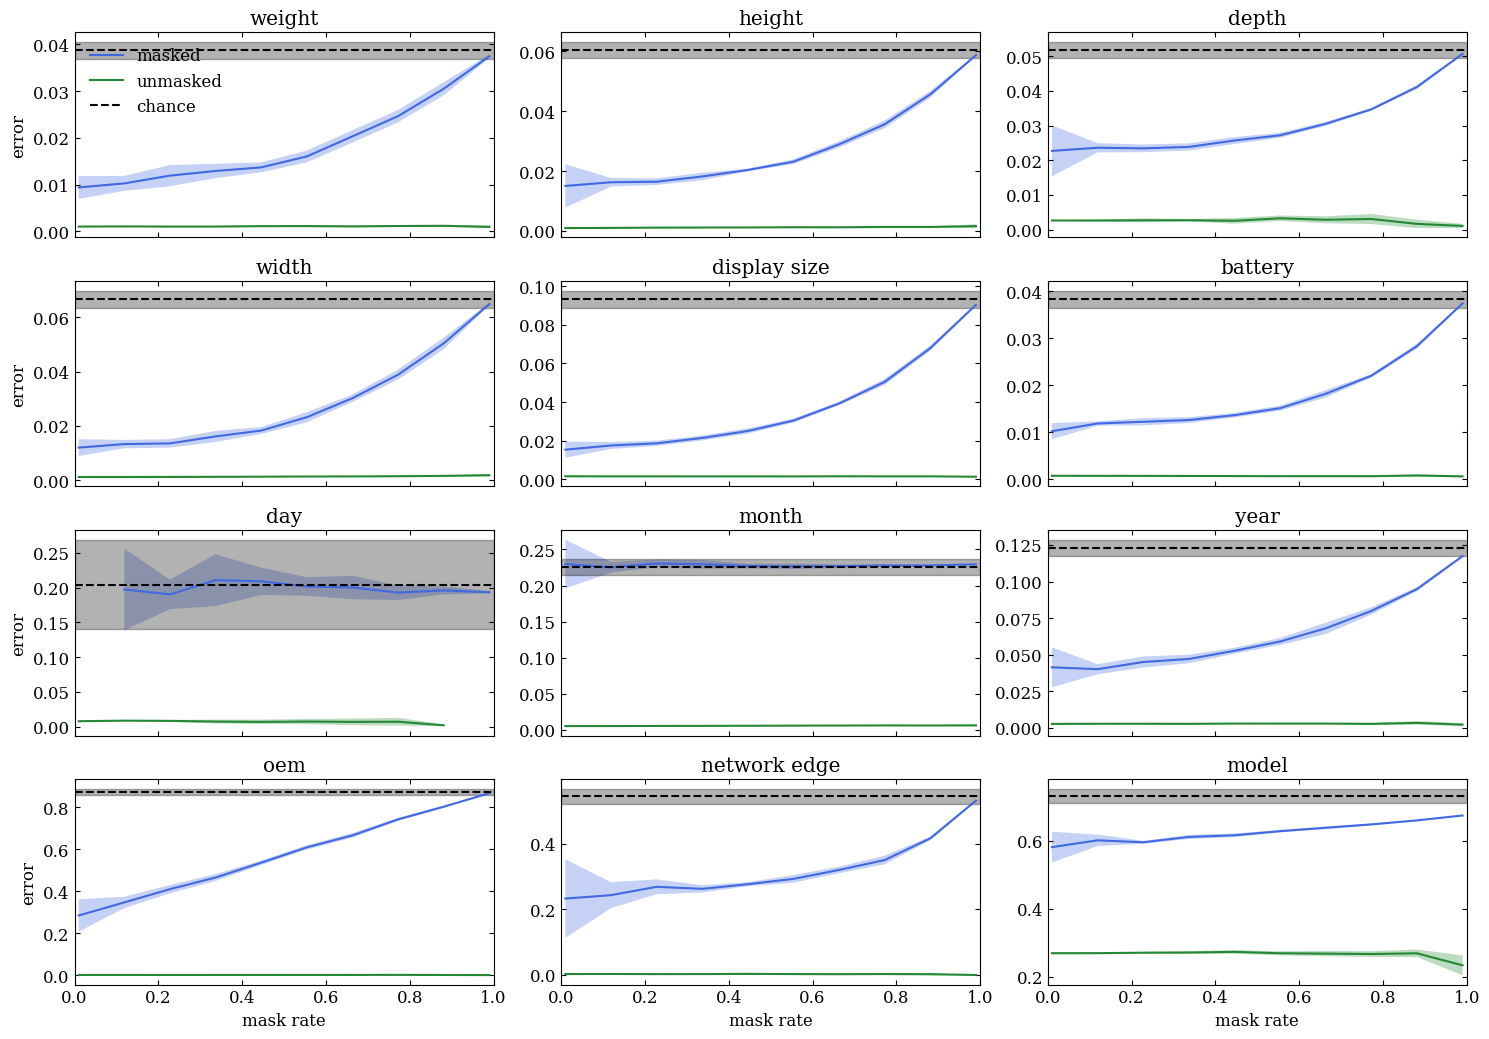

In [14]:
def plot(fields, cols=3):
    fig, axes = plt.subplots(len(fields)//cols, cols, figsize=(cols*5, cols*3.5), sharex=True, sharey=False, dpi=100)
    if len(fields) == 1:
        axes = np.array([[axes]])
    axes = axes.flatten()
    for i, field in enumerate(fields):
        ax = axes[i]
        plt.sca(ax)
        for mask_state in accs[field]:
            # if "std" in mask_state or "average" in mask_state:
            if "std" in mask_state or "average" in mask_state:
                continue
            plt.plot(mask_rates, accs[field][mask_state], label=mask_state)
            plt.fill_between(mask_rates, np.array(accs[field][mask_state]) - np.array(accs[field][mask_state + "_std"]), np.array(accs[field][mask_state]) + np.array(accs[field][mask_state + "_std"]), alpha=0.3)
        plt.axhline(baseline_acc[field], color="black", linestyle="--", label="chance")
        plt.fill_between((0,1), baseline_acc[field] - baseline_err[field], baseline_acc[field] + baseline_err[field], alpha=0.3, color="k")
        # plt.axhline(medians_acc[field], color="black", linestyle=":", label="median guess")
        # plt.axhline(modes_acc[field], color="black", linestyle="-.", label="mode guess")
        plt.xlim(0, 1)
        # plt.ylim(1e-7, 1)
        # plt.yscale("log")
        plt.title(field.split(".")[-1].replace("_", " "))
        if i == 0:
            plt.legend()
        if i//cols == len(fields)//cols - 1:
            plt.xlabel("mask rate")
        if i%cols == 0:
            plt.ylabel("error")
    plt.tight_layout()
    plot_dir = os.path.join(rootdir, f"plots/{model_name}")
    os.makedirs(plot_dir, exist_ok=True)
    fields = [field.split(".")[-1] for field in fields]
    # plt.savefig(os.path.join(plot_dir, f"errorVSmasking{'-'.join(fields)}.png"), dpi=300)

# plot(run.config.fields.all_fields[1:])
plot(run.config.fields.all_fields, cols=3)

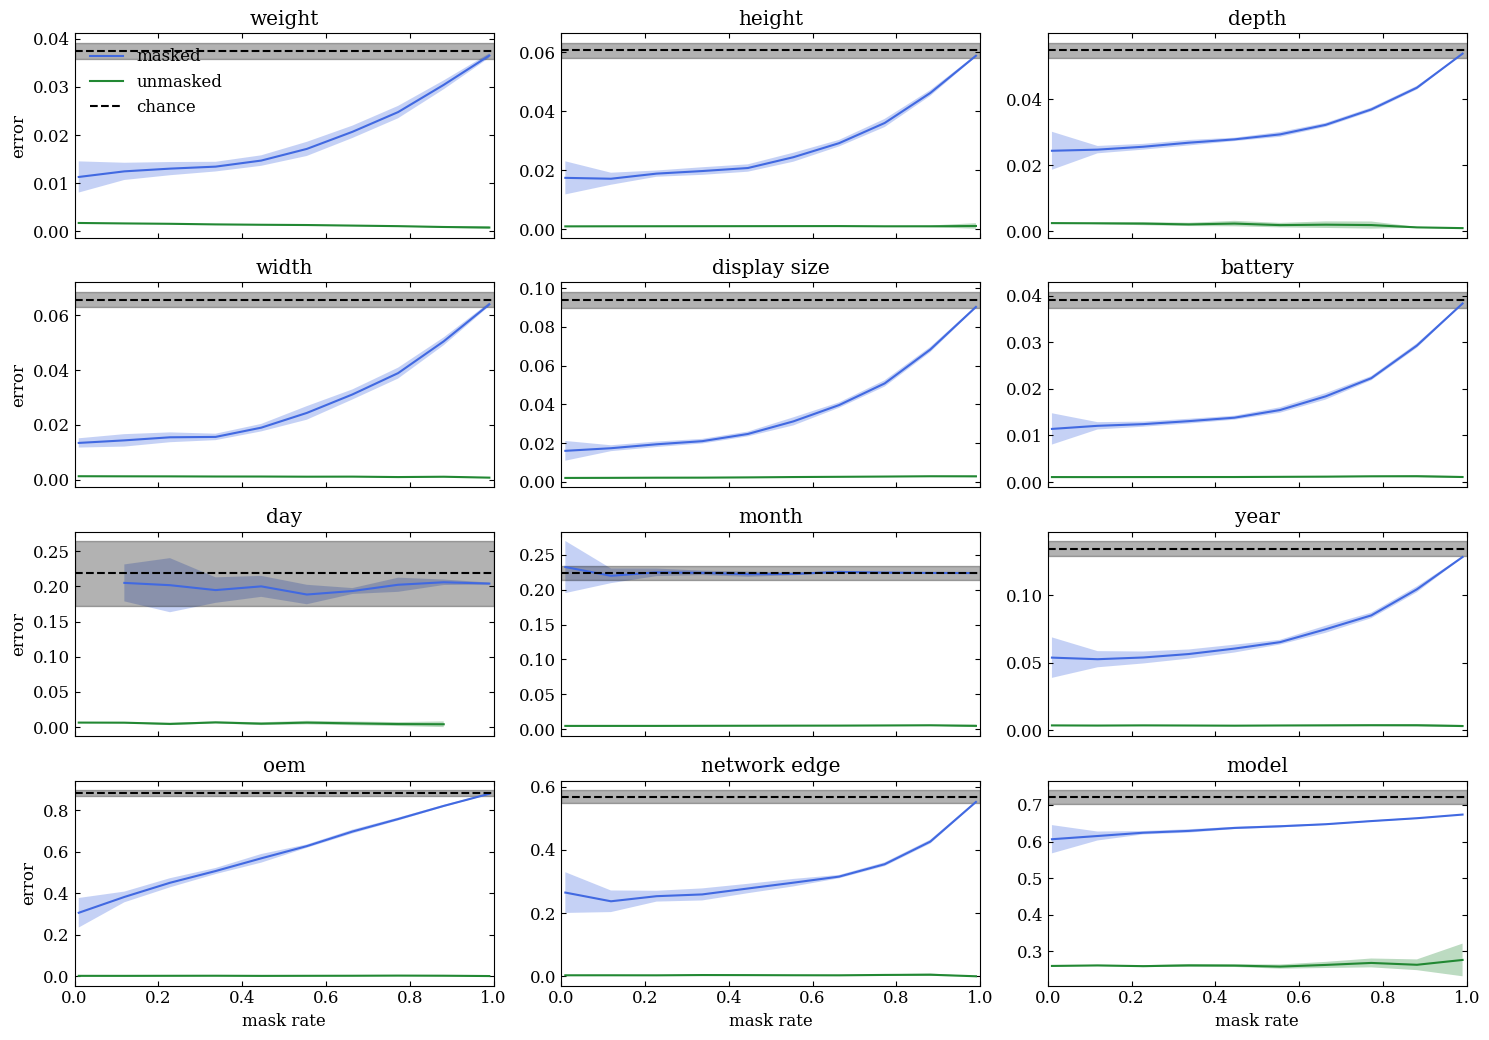

In [ ]:
def plot(fields, cols=3):
    fig, axes = plt.subplots(len(fields)//cols, cols, figsize=(cols*5, cols*3.5), sharex=True, sharey=False, dpi=100)
    if len(fields) == 1:
        axes = np.array([[axes]])
    axes = axes.flatten()
    for i, field in enumerate(fields):
        ax = axes[i]
        plt.sca(ax)
        for mask_state in accs[field]:
            # if "std" in mask_state or "average" in mask_state:
            if "std" in mask_state or "average" in mask_state:
                continue
            plt.plot(mask_rates, accs[field][mask_state], label=mask_state)
            plt.fill_between(mask_rates, np.array(accs[field][mask_state]) - np.array(accs[field][mask_state + "_std"]), np.array(accs[field][mask_state]) + np.array(accs[field][mask_state + "_std"]), alpha=0.3)
        plt.axhline(baseline_acc[field], color="black", linestyle="--", label="chance")
        plt.fill_between((0,1), baseline_acc[field] - baseline_err[field], baseline_acc[field] + baseline_err[field], alpha=0.3, color="k")
        # plt.axhline(medians_acc[field], color="black", linestyle=":", label="median guess")
        # plt.axhline(modes_acc[field], color="black", linestyle="-.", label="mode guess")
        plt.xlim(0, 1)
        # plt.ylim(1e-7, 1)
        # plt.yscale("log")
        plt.title(field.split(".")[-1].replace("_", " "))
        if i == 0:
            plt.legend()
        if i//cols == len(fields)//cols - 1:
            plt.xlabel("mask rate")
        if i%cols == 0:
            plt.ylabel("error")
    plt.tight_layout()
    plot_dir = os.path.join(rootdir, f"plots/{model_name}")
    os.makedirs(plot_dir, exist_ok=True)
    fields = [field.split(".")[-1] for field in fields]
    # plt.savefig(os.path.join(plot_dir, f"errorVSmasking{'-'.join(fields)}.png"), dpi=300)

# plot(run.config.fields.all_fields[1:])
plot(run.config.fields.all_fields, cols=3)

# Various small checks

In [28]:
input_dict = dataset.input_dict.iloc[dataset.val_idx.to(device)
attention_mask = dataset.pad_mask_dict.iloc[dataset.val_idx.to(device)

preds = model.get_predictions(input_dict, attention_mask)
field = "phone.oem"
idx = 7
print((tok:=input_dict[field][idx]), dataset.tokenizer.batch_decode(tok, skip_special_tokens=True))
print((tok:=preds[field][idx].argmax(dim=-1).tolist()), dataset.categorical_id_to_str[field][tok])

tensor([   45,  2943, 50256,     0,     0,     0,     0], device='cuda:0') ['NEC']
25 NEC


In [29]:
field = "phone.model"
idx = slice(10)
predicted_tokens = preds[field][idx].argmax(dim=-1).tolist()
target_tokens = input_dict[field][idx].tolist()
print(*zip(dataset.tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True), dataset.tokenizer.batch_decode(target_tokens, skip_special_tokens=True)), sep="\n")

('X 6ib 6 6', 'Xelibri 6')
('Life TabZ', 'Life View Tab')
('N7676', 'N76')
('Z50', 'Z50')
(' Hate', '968')
('U890', 'U890')
('Timeportport', 'Timeport 280')
('e121', 'e121')
('Lumia303030', 'Lumia 930')
(' Platinum Platinum', '50 Platinum')


In [29]:
# Let's look at some predictions and targets
df = dataset.df.iloc[dataset.train_idx]
target_dict = input_dict.copy()
# first we need to use real class indices instead of the token ids
for field in input_dict.categorical:
    target_dict[field] = input_dict[field + "_idx"]

print("Errors")
print({k:1-v.item() for k,v in accuracy(preds, target_dict).items()})
    
for field in input_dict.categorical:
    counts = df.value_counts(field)
    print("Field:", field)
    pred = preds[field].argmax(dim=-1).tolist()
    print("example predictions")
    print(pred[:10])
    tgt = target_dict[field].tolist()
    print("example targets")
    print(tgt[:10])
    # let's convert predictions and targets to text
    pred_text = dataset.label_to_string(pred, field)
    target_text = dataset.label_to_string(tgt, field)
    print("Text (predictions , targets)")
    print(*list(zip(pred_text, target_text))[:10], sep="\n", end="\n")
    # Now let's look at the model errors and where it made mistakes
    mistakes = [(p, t) for p, t in zip(pred_text, target_text) if p != t and t != ""]
    print("Mistakes")
    print(*mistakes, sep="\n")
    

    for mistake in mistakes:
        predicted_label, target_label = mistake
        if predicted_label not in counts.index:
            txt1 = f"Predicted label '{predicted_label}' not in training set and "
        else:
            txt1 = f"Predicted label '{predicted_label}' has ({counts[predicted_label]}) examples in training set and "
        if target_label not in counts.index:
            print(txt1 + f"target label '{target_label}' not in training set")
        else:
            print(txt1 + f"target label '{target_label}' has ({counts[target_label]}) examples in training set")
            
    print("\n\n")

Errors


{'phone.weight': 0.0017606616020202637, 'phone.height': 0.0009582638740539551, 'phone.depth': 0.0024867653846740723, 'phone.width': 0.0013280510902404785, 'phone.display_size': 0.0020412802696228027, 'phone.battery': 0.0010755062103271484, 'phone.launch.day': 0.006357908248901367, 'phone.launch.month': 0.004661738872528076, 'phone.launch.year': 0.0034446120262145996, 'phone.oem': 0.0009363293647766113, 'phone.network_edge': 0.0030975937843322754, 'phone.model': 0.25963300466537476}
Field: phone.oem
example predictions
[44, 72, 27, 61, 35, 18, 24, 25, 27, 81]
example targets
[44, 72, 27, 61, 35, 18, 24, 25, 27, 81]
Text (predictions , targets)
('Siemens', 'Siemens')
('BLU', 'BLU')
('Nokia', 'Nokia')
('Yezz', 'Yezz')
('Philips', 'Philips')
('LG', 'LG')
('Motorola', 'Motorola')
('NEC', 'NEC')
('Nokia', 'Nokia')
('Archos', 'Archos')
Mistakes
('BenQ-Siemens', 'Fujitsu Siemens')
('Pantech', 'Thuraya')
Predicted label 'BenQ-Siemens' has (24) examples in training set and target label 'Fujitsu 

In [31]:
token_ids = dataset.tokenizer([predicted_label, target_label])["input_ids"]
print(*dataset.tokenizer.batch_decode(token_ids[0]), sep="|")
print(*dataset.tokenizer.batch_decode(token_ids[1]), sep="|")

Up to 60 kbps
Up to 384 kbps


In [32]:
field = "phone.launch.day"
# field_prototypes = field_prototypes_dict[field]
# unembed = model.numerical_embed(field_prototypes)
mask = input_dict[field] != dataset.numerical_pad_token_id
tgt = input_dict[field][mask]
tgt = dataset.reverse_transform({field:tgt})[field]
print(tgt)
pred = preds[field][mask]
# pred = (pred @ unembed.T).argmax(dim=-1)
# pred = field_prototypes[pred].long()
pred = dataset.reverse_transform({field:pred.view(-1)})[field]
print(pred)
print((pred.round() == tgt.round()).float().mean().item())


tensor([30.0000,  5.0000,  8.0000, 20.0000,  5.0000, 23.0000, 25.0000, 18.0000,
        27.0000, 29.0000, 24.0000,  5.0000,  3.0000,  6.0000, 26.0000,  6.0000,
         5.0000,  4.0000,  5.0000,  6.0000,  5.0000,  6.0000, 17.0000, 11.0000,
        15.0000, 20.0000,  4.0000, 23.0000, 22.0000,  7.0000,  3.0000, 30.0000,
        30.0000, 23.0000, 14.0000, 28.0000,  8.0000,  7.0000, 19.0000,  8.0000,
        15.0000, 17.0000, 25.0000,  6.0000, 17.0000,  9.0000, 26.0000, 25.0000,
        25.0000, 19.0000, 30.0000,  9.0000,  8.0000, 24.0000, 26.0000, 22.0000,
        28.0000, 19.0000, 24.0000, 17.0000, 30.0000, 22.0000, 20.0000, 26.0000,
        26.0000,  1.0000, 16.0000, 17.0000, 20.0000,  6.0000, 30.0000, 24.0000,
        31.0000, 17.0000, 23.0000, 28.0000,  8.0000, 15.0000, 10.0000,  8.0000,
        17.0000, 16.0000, 17.0000,  5.0000, 28.0000, 30.0000, 16.0000, 25.0000,
         6.0000])
tensor([29.5574,  4.9179,  7.9675, 19.8596,  4.9931, 22.9357, 24.9506, 17.8317,
        26.9886, 29.05